# Part C · Multinomial (Softmax) Logistic Regression — From Scratch

## 7. Theory

### Derive the gradient of the log-likelihood function for muticlass classification (check the notebook for session 4)

### Derivación del Gradiente de la Log-Verosimilitud en Softmax Regression

Recordemos que la log-verosimilitud para un conjunto de datos 
$\mathcal{D} = \{(x^{(i)}, y^{(i)})\}_{i=1}^n$ es

$$
\ell(\theta)
= \sum_{i=1}^n \theta^\top_{y^{(i)}} x^{(i)}
- \sum_{i=1}^n \log \left( \sum_{j=1}^K \exp(\theta_j^\top x^{(i)}) \right).
$$

donde $\theta_l \in \mathbb{R}^d$ es el vector de parámetros para la clase $l$.

---

### 1. Derivada del primer término

Sea

$$
T_1(\theta) = \sum_{i=1}^n \theta^\top_{y^{(i)}} x^{(i)}.
$$

Al derivar respecto a $\theta_l$, sólo aportan los ejemplos donde $y^{(i)} = l$:

$$
\frac{\partial T_1}{\partial \theta_l}
= \sum_{i=1}^n \mathbf{1}\{y^{(i)}=l\}\, x^{(i)}.
$$

---

### 2. Derivada del segundo término

Sea

$$
T_2(\theta) = \sum_{i=1}^n \log \left( \sum_{j=1}^K \exp(\theta_j^\top x^{(i)}) \right).
$$

Usando la regla de la cadena y notando que 
$\frac{\partial}{\partial \theta_l}(\theta_l^\top x^{(i)}) = x^{(i)}$, tenemos

$$
\frac{\partial}{\partial \theta_l}
\log \left( \sum_{j=1}^K \exp(\theta_j^\top x^{(i)}) \right)
= \frac{\exp(\theta_l^\top x^{(i)})}{\sum_{j} \exp(\theta_j^\top x^{(i)})}\, x^{(i)}
= \sigma(z^{(i)})_l\, x^{(i)},
$$

donde $\sigma(z^{(i)})_l = p_\theta(y=l\mid x^{(i)})$.  

Por lo tanto,

$$
\frac{\partial T_2}{\partial \theta_l}
= \sum_{i=1}^n \sigma(z^{(i)})_l\, x^{(i)}.
$$

---

### 3. Gradiente total

Como $\ell(\theta) = T_1(\theta) - T_2(\theta)$, se tiene

$$
\boxed{
\frac{\partial \ell(\theta)}{\partial \theta_l}
= \sum_{i=1}^n \Big( \mathbf{1}\{y^{(i)}=l\} - \sigma(z^{(i)})_l \Big)\, x^{(i)}
}.
$$


## 8. Implementation

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [26]:
def softmax(z):
    # Estabilidad numérica
    z = z - np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def compute_log_likelihood(X, y, W):
    n = X.shape[0]
    scores = X @ W
    probs = softmax(scores)
    log_likelihood = np.sum(np.log(probs[np.arange(n), y]))
    return log_likelihood

def gradient_descent(X, y, num_classes, lr=0.1, epochs=5000, tol=1e-6):
    n_samples, n_features = X.shape
    W = np.zeros((n_features, num_classes))
    prev_ll = -np.inf
    ll_history = []

    for epoch in range(epochs):
        scores = X @ W
        probs = softmax(scores)
        y_onehot = np.zeros_like(probs)
        y_onehot[np.arange(n_samples), y] = 1
        grad = X.T @ (y_onehot - probs)
        W += lr * grad / n_samples

        ll = compute_log_likelihood(X, y, W)
        ll_history.append(ll)

        if np.abs(ll - prev_ll) < tol:
            print(f'Convergencia en epoch {epoch}')
            break
        prev_ll = ll

    return W, ll_history

def predict(X, W):
    scores = X @ W
    probs = softmax(scores)
    return np.argmax(probs, axis=1)

In [27]:
data = load_wine()
X = data.data
y = data.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

num_classes = len(np.unique(y))
num_features = X_train.shape[1]

# Entrenar modelo con descenso por gradiente
W, ll_history = gradient_descent(X_train, y_train, num_classes, lr=0.1, epochs=10000)

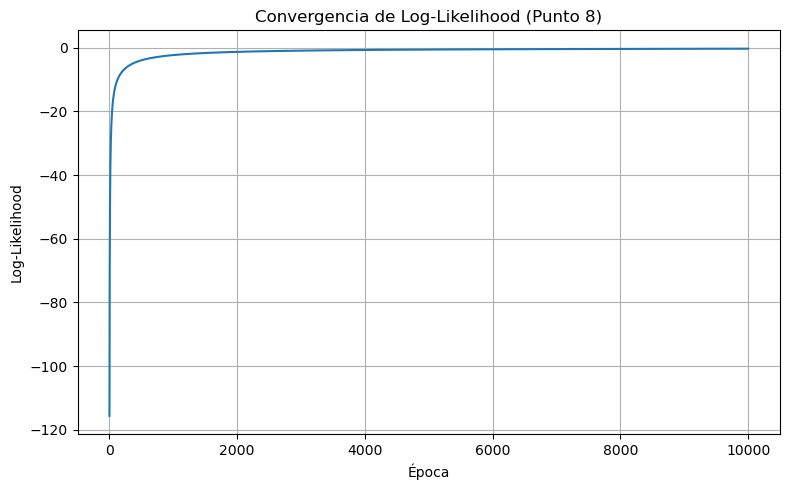

In [28]:
# Graficar convergencia log-likelihood
plt.figure(figsize=(8, 5))
plt.plot(ll_history)
plt.xlabel('Época')
plt.ylabel('Log-Likelihood')
plt.title('Convergencia de Log-Likelihood (Punto 8)')
plt.grid(True)
plt.tight_layout()
plt.show()

## 9. Evaluation

In [29]:
# Evaluar en test
y_pred_test = predict(X_test, W)
acc = accuracy_score(y_test, y_pred_test)
print("=== Punto 8: Evaluación modelo desde cero ===")
print(f"Accuracy: {acc:.4f}")

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_test, average=None)
cm = confusion_matrix(y_test, y_pred_test)

=== Punto 8: Evaluación modelo desde cero ===
Accuracy: 0.9815


In [30]:
# Comparar con LogisticRegression

print("\nMétricas por clase (modelo propio):")
for i, (p, r) in enumerate(zip(precision, recall)):
    print(f"Clase {i}: Precision={p:.4f}, Recall={r:.4f}")
print("\nMatriz de confusión (modelo propio):")
print(cm)

clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=10000)
clf.fit(X_train, y_train)
y_pred_sklearn = clf.predict(X_test)

acc_sklearn = accuracy_score(y_test, y_pred_sklearn)
precision_sklearn, recall_sklearn, _, _ = precision_recall_fscore_support(y_test, y_pred_sklearn, average=None)
cm_sklearn = confusion_matrix(y_test, y_pred_sklearn)

print("\nMétricas por clase (scikit-learn):")
for i, (p, r) in enumerate(zip(precision_sklearn, recall_sklearn)):
    print(f"Clase {i}: Precision={p:.4f}, Recall={r:.4f}")
print("\nMatriz de confusión (scikit-learn):")
print(cm_sklearn)

print(f"\nAccuracy (modelo propio): {acc:.4f}")
print(f"Accuracy (scikit-learn): {acc_sklearn:.4f}")


Métricas por clase (modelo propio):
Clase 0: Precision=1.0000, Recall=1.0000
Clase 1: Precision=1.0000, Recall=0.9524
Clase 2: Precision=0.9375, Recall=1.0000

Matriz de confusión (modelo propio):
[[18  0  0]
 [ 0 20  1]
 [ 0  0 15]]

Métricas por clase (scikit-learn):
Clase 0: Precision=0.9474, Recall=1.0000
Clase 1: Precision=1.0000, Recall=0.9524
Clase 2: Precision=1.0000, Recall=1.0000

Matriz de confusión (scikit-learn):
[[18  0  0]
 [ 1 20  0]
 [ 0  0 15]]

Accuracy (modelo propio): 0.9815
Accuracy (scikit-learn): 0.9815


c:\Users\JorgeData\.conda\envs\pytest\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
